# HST graphs

In [2]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.style as style
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
%matplotlib inline
style.use('seaborn-v0_8-ticks')


*Available targets = { 'h', 'GV1', 'GV3', 'GV51', 'MB4', 'MB8', 'MB10', 'MB18'}*

<Figure size 640x480 with 0 Axes>

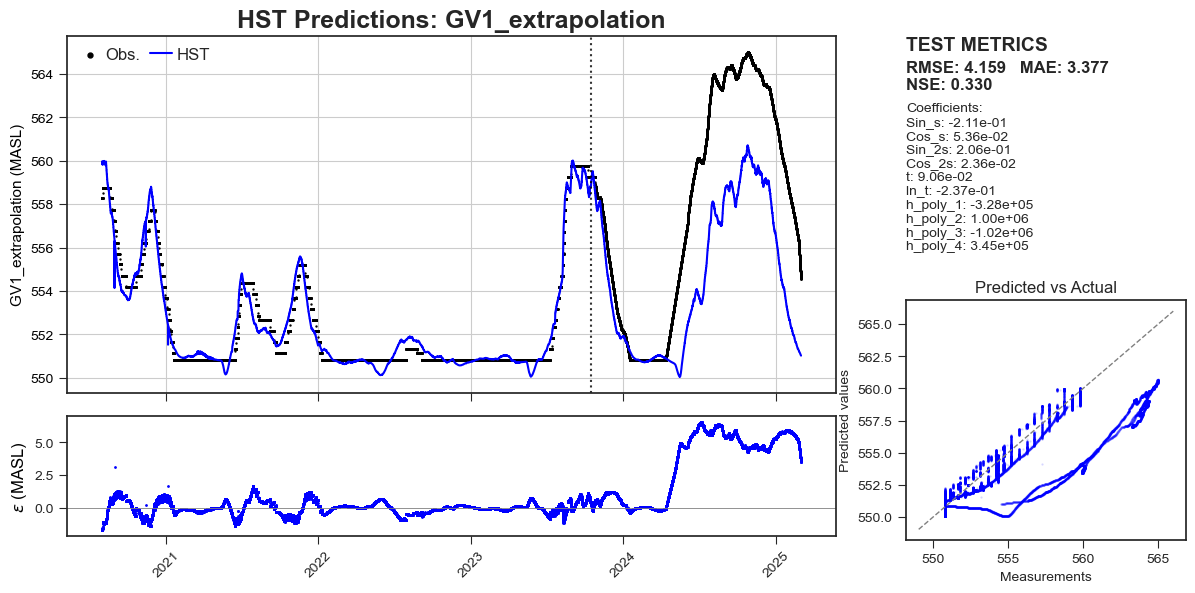

In [ ]:
# Set target
target = 'GV1_extrapolation'
unit = 'MASL' if 'GV' in target else 'L/s' if 'MB' in target else None
color_HST = 'blue'

with open(f'plotting_data/HST/HST_{target}_plotting_data.pkl', 'rb') as f:
    plotting_data = pickle.load(f)

# Extract data for plotting
dates = plotting_data['dates']
y = plotting_data['y']
predictions = plotting_data['predictions']
split_idx = plotting_data['split_index']
coefficients = plotting_data['coefficients']
RMSE = plotting_data['RMSE']
MAE = plotting_data['MAE']
NSE = plotting_data['NSE']
KGE = plotting_data['KGE']

# Splitting
y_test = y.iloc[split_idx:]
y_train = y.iloc[:split_idx]
train_predictions = predictions[:split_idx]
test_predictions = predictions[split_idx:]
test_dates = dates.iloc[split_idx:]

plt.clf()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)  

# Data and predictions
ax1.scatter(dates, y, color='black', s=0.5, label='Obs.')
# ax1.plot(dates, y, color='black', linewidth=0.5, alpha=0.3)
ax1.plot(dates, predictions, color=color_HST, linewidth=1.5, label='HST')
ax1.axvline(x=dates.iloc[split_idx], color='black', alpha=0.8, linestyle=':')
ax1.set_ylabel(f'{target} ({unit})', color='black', fontsize=11)
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left', fontsize=12, ncols=2, markerscale=5, \
           columnspacing=0.6, handlelength=1.3, handletextpad=0.3, borderpad=0.2)
ax1.set_title(f'HST Predictions: {target}', fontsize=18, fontweight='bold')
ax1.grid()

# Residuals
residuals = y - predictions
ax2.scatter(dates, residuals, color=color_HST, s=1)
ax2.axhline(y=0, color='gray', linewidth=0.6, linestyle='-')
ax2.set_ylabel(rf'$\epsilon$ ({unit})', color='black', fontsize=12)
# ax2.set_ylim(-2, 2)
# ax2.set_yticks(range(-2, 3))
# ax2.tick_params(axis='y', labelcolor='black')

# Formatting
plt.xticks(rotation=45)  
fig.tight_layout()  

# Text
fig.subplots_adjust(right=0.6)
title_text = "TEST METRICS"
rmse_text = f'RMSE: {RMSE:.3f}'
mae_text = f'MAE: {MAE:.3f}'
NSE_text = f"NSE: {NSE:.3f}"
KGE_text = f"KGE: {KGE:.3f}"

metrics_text_1 = '   '.join([rmse_text, mae_text])
metrics_text_2 = '   '.join([NSE_text, KGE_text])
metrics_text = '\n'.join([metrics_text_1, metrics_text_2])
coeff_text = 'Coefficients:\n' + '\n'.join([f'{term}: {coeff:.2e}' for term, coeff in coefficients.items()])
fig.text(0.65, 0.93, title_text, verticalalignment='top', fontweight='bold', fontsize=14)
fig.text(0.65, 0.89, metrics_text, verticalalignment='top', fontweight='bold', fontsize=12)
fig.text(0.65, 0.82, coeff_text, verticalalignment='top')

# Scatter plot for predicted vs measured values
ax3 = fig.add_axes([0.65, 0.09, 0.2, 0.4]) #type: ignore (Manually placed)

# Add a grey diagonal line from bottom-left to top-right
min_val = min(y.min(), predictions.min())-1
max_val = max(y.max(), predictions.max())+1
ax3.plot([min_val, max_val], [min_val, max_val], color='grey', linestyle='--', linewidth=1)

# Plot
ax3.scatter(y, predictions, color=color_HST, alpha=0.1, s=0.5, marker='D')
ax3.set_xlabel(f'Measurements', fontsize=10)
ax3.set_ylabel(f'Predicted values', fontsize=10)
ax3.set_title('Predicted vs Actual', fontsize=12)

plt.show()

# # Optimize quality by saving the plot with high DPI
# plt.savefig('high_quality_plot.png', dpi=300, bbox_inches='tight')

# # Alternatively, saving in vector format (SVG or PDF) to maintain quality on zoom
# plt.savefig('high_quality_plot_SVG.svg', dpi=300, bbox_inches='tight')


Length of y_test: 12046
Length of residuals: 12046
Length of anomaly_labels: 12046
Threshold for anomalies: 0.5421456618284991
Anomalies count: 4358
Normal count: 7688
Residuals near threshold:
Just below threshold: 0.5420889438039467
Just above threshold: 0.5422251875652364


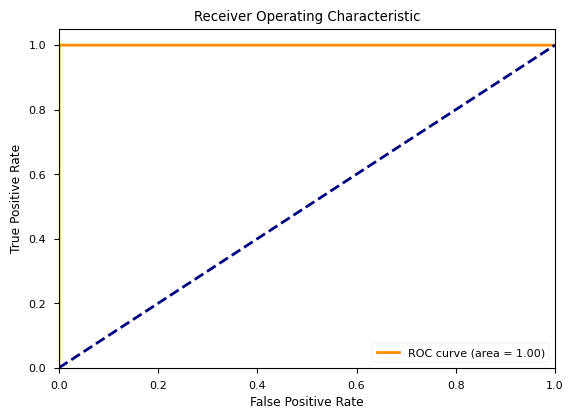

ROC AUC: 1.0


In [4]:
test_residuals = np.abs(y_test - test_predictions)
train_residuals = np.abs(y_train - train_predictions)
threshold = np.percentile(train_residuals, 70)
test_anomaly_labels = (test_residuals > threshold).astype(int)
fpr, tpr, _ = roc_curve(test_anomaly_labels, test_residuals)
roc_auc = auc(fpr, tpr)
print("Length of y_test:", len(y_test))
print("Length of residuals:", len(test_residuals))
print("Length of anomaly_labels:", len(test_anomaly_labels))
print("Threshold for anomalies:", threshold)
print("Anomalies count:", np.sum(test_anomaly_labels))
print("Normal count:", len(test_anomaly_labels) - np.sum(test_anomaly_labels))
print("Residuals near threshold:")
print("Just below threshold:", test_residuals[test_residuals < threshold].max())
print("Just above threshold:", test_residuals[test_residuals > threshold].min())

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
#plt.scatter(fpr, tpr, c=thresholds, cmap='coolwarm', label='Threshold value')
#plt.colorbar(label='Threshold')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("ROC AUC:", roc_auc)